In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline
import seaborn as sns
import platform
from matplotlib import font_manager , rc

if platform.system() == 'Darwin':
  rc('font' , family = 'AppleGothic')
elif platform.system() == 'Windows':
  path = 'C:/Windows/Fonts/malgun.ttf'
  font_name = font_manager.FontProperties(fname = path).get_name()
  rc('font' , family = font_name)
else:
  print('모름')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

# Setting

In [2]:
# 파이썬 버전 ≥ 3.5 필수
import sys
assert sys.version_info >= (3 , 5)

In [3]:
sys.version

'3.8.17 (default, Jul  5 2023, 20:35:33) [MSC v.1916 64 bit (AMD64)]'

# 문제 정의
 - 2017년 NBA 농구 선수의 경기기록을 학습해서 포지션 예측
 - 최적의 SW 파라미터 찾기

In [4]:
df = pd.read_csv('basketball_stat.csv')

In [5]:
x = df.drop('Pos' , axis = 1)
y = df['Pos']

x.shape , y.shape

((100, 7), (100,))

# 모델 구현

In [6]:
from sklearn.model_selection import train_test_split

x = df[['3P','BLK']]

x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2 , random_state = 0)

## SVM 최적의 파라미터 찾기

1. C(cost) : 비용 , 결정경계선의 마진을 결정하는 파라미터
 - 클수록 하드마진 , 작을수록 소프트마진
2. gamma : 커널의 데이터포인트의 표준편차를 결정하는 파라미터
 - 'scale' : 결정 경계를 얼마나 유연하게 그릴건지를 정함
 - 클수록 과대적합의 위험

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix
from sklearn.svm import SVC

In [10]:
# C(0.1)
# kernel : rbf
# kernel은 데이터셋의 형태에 따라 다르게 지정
# 선형 데이터셋일 경우 'linear' , 비선형 데이터셋의 경우 'poly(다항식)' , 'rbf(가우시안)'
def svc_param_selection(x_train , y_train , nfolds):
    svm_params = {'kernel' : ['rbf'] , 'gamma' : [0.00001 , 0.0001 , 0.001 , 0.01 , 0.1 , 1] , 'C' : [0.01 , 0.1 , 1 , 10 , 100 , 1000]}
    clf = GridSearchCV(SVC() , svm_params , cv = nfolds)
    clf.fit(x_train , y_train)
    print(clf.best_params_)
    
    return clf

In [11]:
clf = svc_param_selection(x_train , y_train , 10)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [209]:
x_train = df[['3P','BLK']]
y_train = df[['Pos']]

clf = svc_param_selection(x_train , y_train , 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [210]:
svc_param_selection(x_train , y , 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']})

In [211]:
clf1 = svc_param_selection(x_train , y , 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [212]:
clf1.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


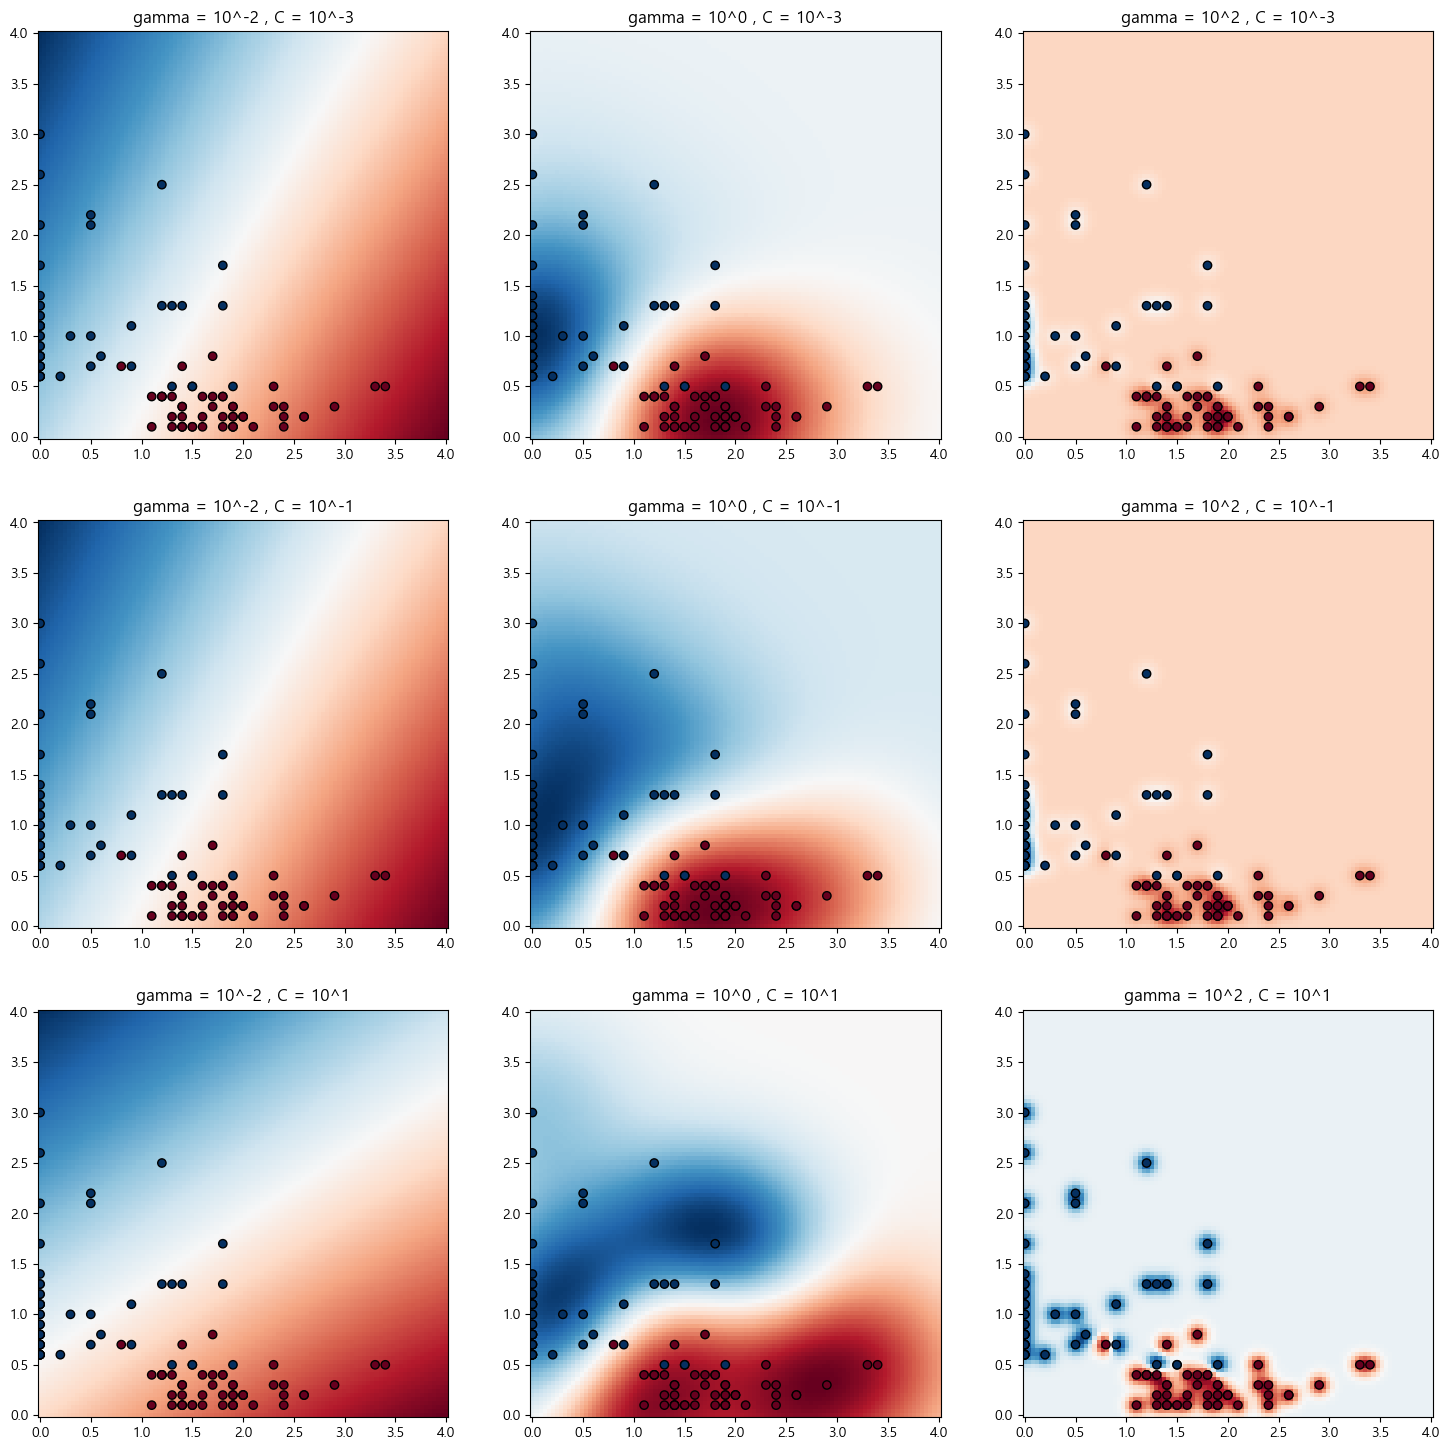

In [213]:
clf1 = svc_param_selection(x_train , y , 10)
clf1.best_params_
c_list = []
c_list.append(clf1.best_params_['C']*0.01)
c_list.append(clf1.best_params_['C'])
c_list.append(clf1.best_params_['C']*100)

gamma_list = []
gamma_list.append(clf1.best_params_['gamma']*0.01)
gamma_list.append(clf1.best_params_['gamma'])
gamma_list.append(clf1.best_params_['gamma']*100)

x_train = df[['3P','BLK']]
y_train = df['Pos'].tolist()

position = []

for p in y:
    if p == 'C':
        position.append(0)
    else:
        position.append(1)
        
classifiers = []

for c in c_list:
    for gamma in gamma_list:
        clf = SVC(C = c , gamma = gamma)
        clf.fit(x_train , y_train)
        classifiers.append((c , gamma , clf))
        
plt.figure(figsize = (18,18))

xx , yy = np.meshgrid(np.linspace(0,4,100) , np.linspace(0,4,100))

for (k , (c , gamma , clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel() , yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(3,3,k+1)
    plt.title('gamma = 10^%d , C = 10^%d' % (np.log10(gamma) , np.log10(c)))
    
    plt.pcolormesh(xx , yy , -Z , cmap = plt.cm.RdBu)
    plt.scatter(x['3P'] , x['BLK'] , c = position , cmap = plt.cm.RdBu_r , edgecolors = 'k')

# 검증과 테스트

In [214]:
pred = clf.predict(x_test[['3P','BLK']])

In [215]:
print(classification_report(y_test , pred))

print('Accuracuy : ' , accuracy_score(y_test , pred))

              precision    recall  f1-score   support

           C       1.00      0.91      0.95        11
          SG       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

Accuracuy :  0.95


# 보고서

In [216]:
comparison = pd.DataFrame({'prediction' : pred , 'Actual' : y_test})
comparison

,prediction,Actual
26,SG,SG
86,SG,SG
2,C,C
55,SG,SG
75,C,C
93,C,C
16,C,C
73,SG,SG
54,SG,C
95,C,C


# 확인학습

 - iris 붓꽃데이터 중 setosa와 versicolor만 선택하여 해당 데이터셋을 이용한 SVM 선형 분류

## 데이터셋 로딩

In [217]:
from sklearn.datasets import load_iris

iris = load_iris()

In [218]:
x = iris.data[iris.target != 2]
y = iris.target[iris.target != 2]

In [219]:
x.shape , y.shape

((100, 4), (100,))

In [220]:
data = pd.DataFrame(x , columns = iris.feature_names)

In [221]:
data['target'] = y

In [222]:
data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [223]:
data.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [224]:
data.columns = ['sepal_length', 'sepal_width', 'petal_length',
       'petal_width', 'target']

In [225]:
data

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


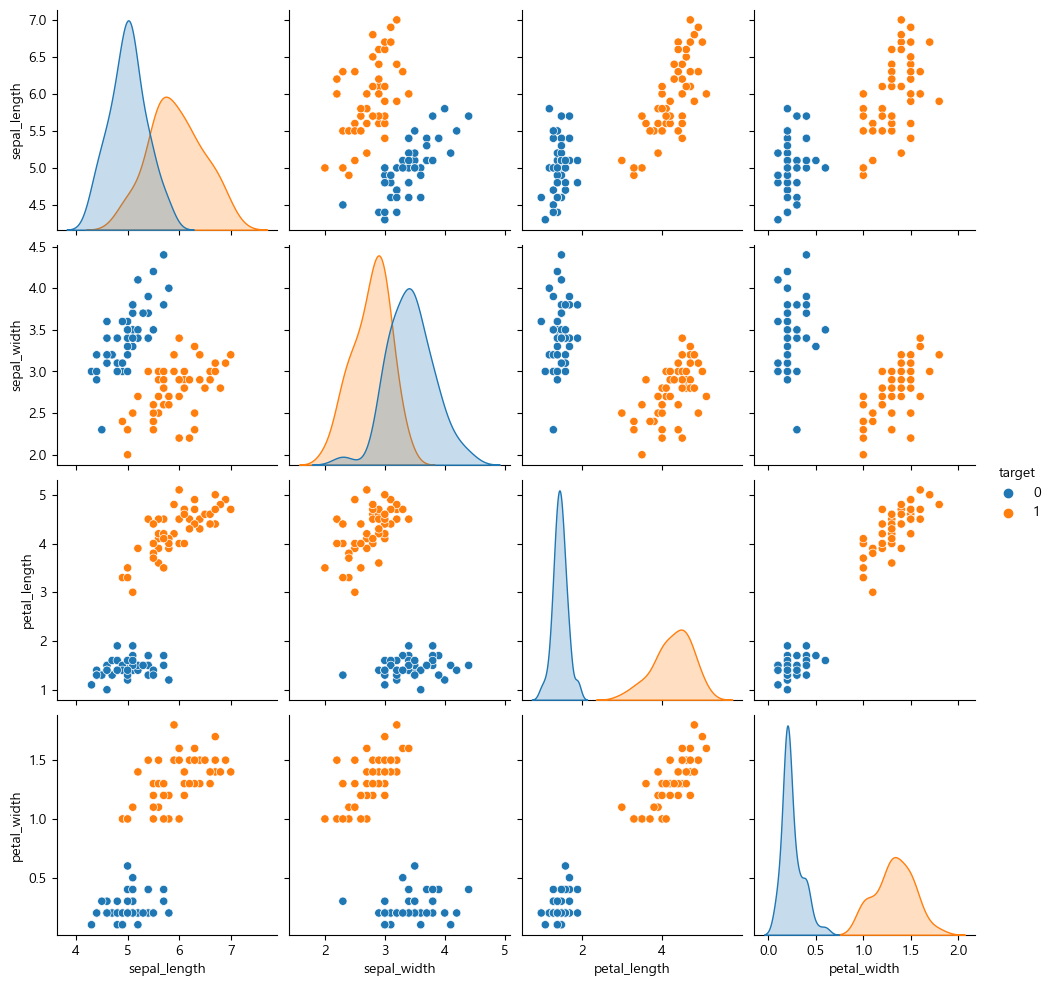

In [226]:
sns.pairplot(data , hue = 'target')

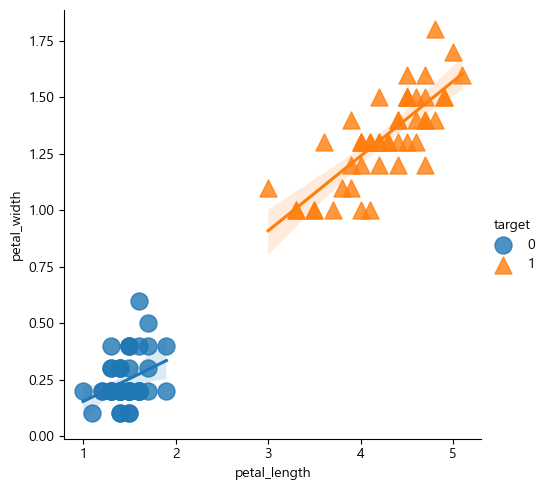

In [227]:
sns.lmplot(x = 'petal_length',y = 'petal_width' , data = data , scatter_kws = {'s' : 150} , hue = 'target' , markers = ['o','^'])

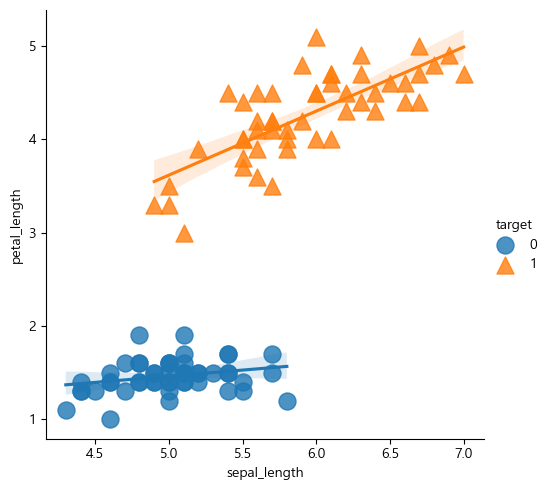

In [228]:
sns.lmplot(x = 'sepal_length',y = 'petal_length' , data = data , scatter_kws = {'s' : 150} , hue = 'target' , markers = ['o','^'])

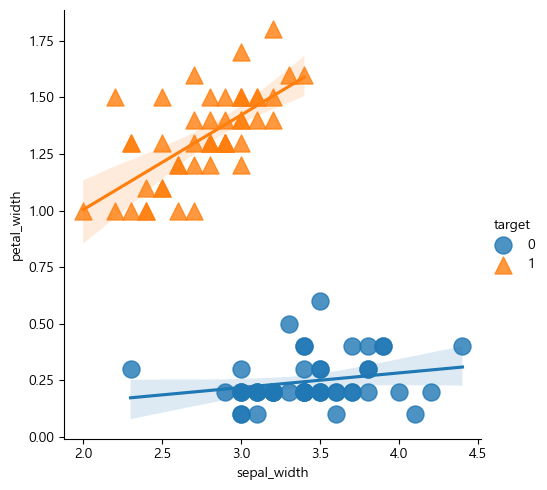

In [229]:
sns.lmplot(x = 'sepal_width',y = 'petal_width' , data = data , scatter_kws = {'s' : 150} , hue = 'target' , markers = ['o','^'])

- 모두 분류가 잘 되어 있다. sepal_width , petal_width를 이용하자

In [230]:
x = data[['sepal_width','petal_width']]

y = data.target

In [231]:
from sklearn.model_selection import train_test_split

train_input , test_input , train_target , test_target = train_test_split(x , y , test_size = 0.2 , random_state = 0)

In [232]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report , accuracy_score

In [233]:
params = {'C' : [0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10],
         'kernel' : ['linear','poly','rbf']}

In [234]:
gs = GridSearchCV(SVC() , params , cv = 10)
gs.fit(train_input , train_target)

print(gs.best_params_)

{'C': 0.1, 'kernel': 'linear'}


In [235]:
svc = SVC(C = 0.1 , kernel = 'linear')

In [236]:
svc.fit(train_input , train_target)

print(classification_report(test_target , svc.predict(test_input)))
print('Accuracy : ' , accuracy_score(test_target , svc.predict(test_input)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy :  1.0


## 보고서

In [237]:
prediction = pd.DataFrame({'prediction' : svc.predict(test_input) , 'Actual' : test_target})
prediction

,prediction,Actual
26,0,0
86,1,1
2,0,0
55,1,1
75,1,1
93,1,1
16,0,0
73,1,1
54,1,1
95,1,1


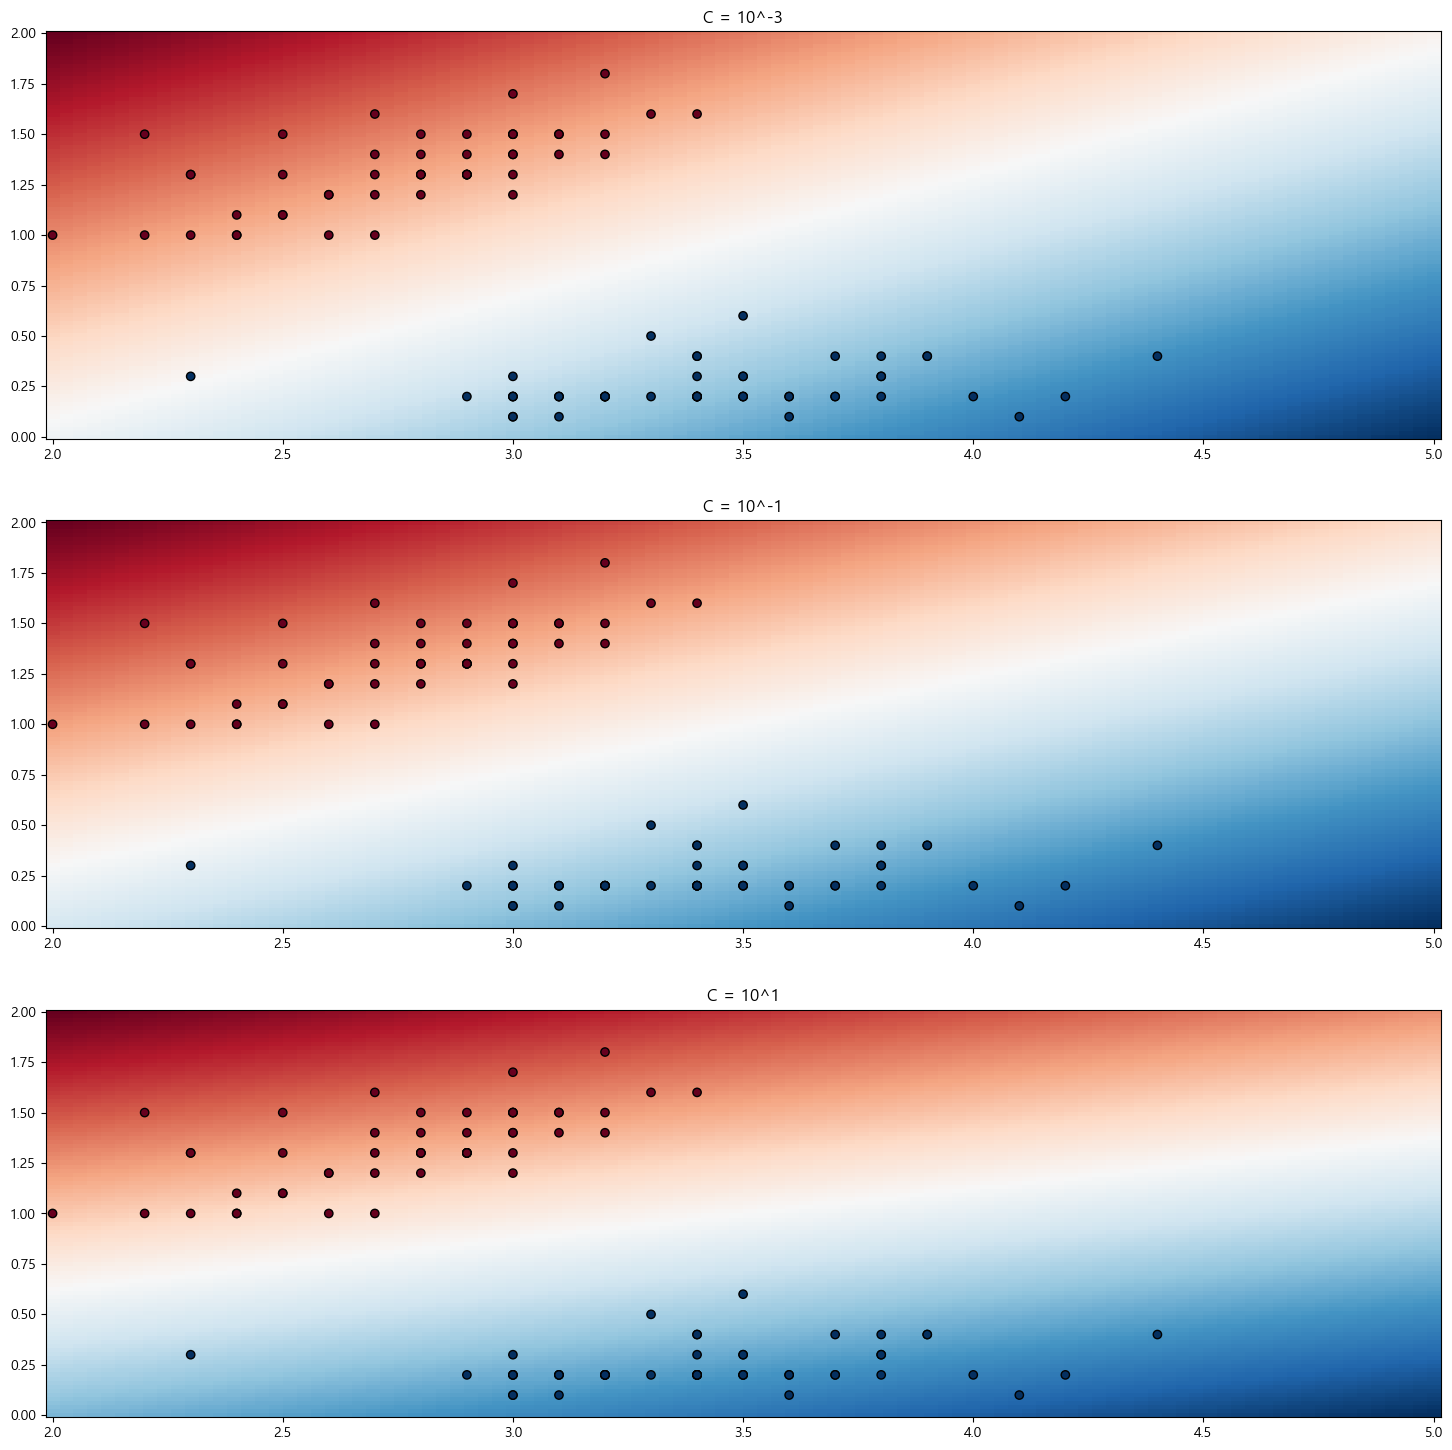

In [238]:
c_list = []
c_list.append(gs.best_params_['C']*0.01)
c_list.append(gs.best_params_['C'])
c_list.append(gs.best_params_['C']*100)

position = data.target
classifiers = []

for c in c_list:
    clf = SVC(C = c , kernel = 'linear')
    clf.fit(train_input , train_target)
    classifiers.append((c , clf))
        
plt.figure(figsize = (18,18))

xx , yy = np.meshgrid(np.linspace(2,5,100) , np.linspace(0,2,100))

for (k , (c ,clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel() , yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.subplot(3,1,k+1)
    plt.title('C = 10^%d' % np.log10(c))
    
    plt.pcolormesh(xx , yy , -Z , cmap = plt.cm.RdBu)
    plt.scatter(data['sepal_width'] , data['petal_width'] , c = position , cmap = plt.cm.RdBu_r , edgecolors = 'k')

- 위 그림에서 1행 2열이 best_params_에 있는 위치이다.